In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
import matplotlib.pyplot as plt 
from IPython.display import clear_output
import torchvision.transforms as transforms
import os

## Импортируем датасет CIFAR-10

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=transform
)



Files already downloaded and verified
Files already downloaded and verified


## Визуализируем данные

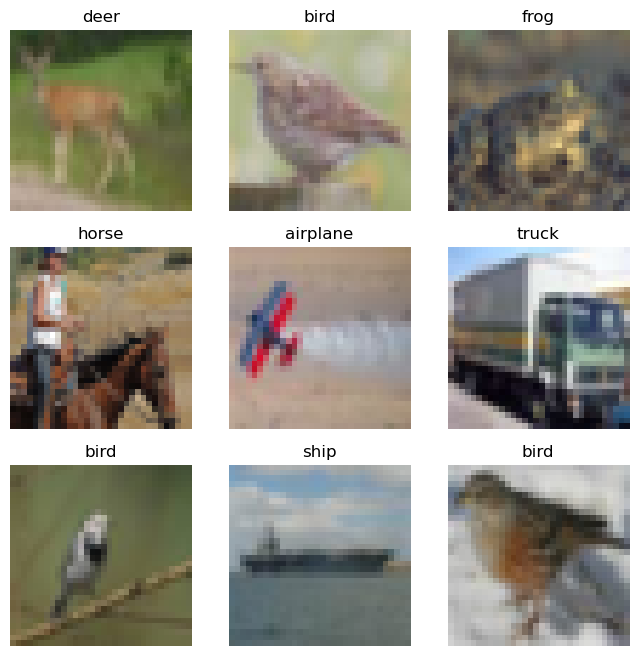

In [3]:
label_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    img = img / 2 + 0.5 # unnormalize
    figure.add_subplot(cols, rows, i)
    plt.title(label_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()

## Создаем DataLoaders

Feature batch size: torch.Size([4, 3, 32, 32])
Labels batch size: torch.Size([4])


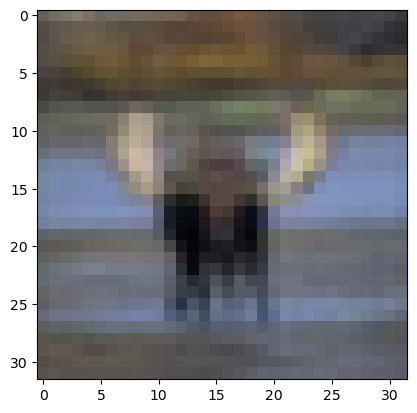

Label: deer


In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# display random image with label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch size: {train_features.size()}")
print(f"Labels batch size: {train_labels.size()}")
img = train_features[0].squeeze().permute(1, 2, 0)
img = img / 2 + 0.5 # unnomalize
label = train_labels[0].item()
plt.imshow(img)
plt.show()
print(f"Label: {label_map[label]}")

## Создаем модель

In [5]:
from torch import nn
import torch.nn.functional as F

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_channels=3, out_channels=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_channels)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [7]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Подготовка к обучению

#### Оценка точности

In [8]:
class AverageMeters(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.cnt = 0
        self.sum = 0
        self.val = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

In [9]:
def accuracy(pred, target, topk=(1,)):
    batch_size = target.size(0)
    correct = (pred.argmax(1) == target).type(torch.float).sum().item()

    res = []
    res.append(correct * (100 / batch_size))

    return res

#### Выбор девайса для работы

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


NeuralNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

#### Циклы обучения и валидации

In [11]:
def train_loop(dataloader, model, criterion, optimizer):
    losses = AverageMeters()
    accs = AverageMeters()

    # switch to train mode
    model.train()

    for _, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        
        # compute output
        pred = model(data)
        loss = criterion(pred, target)

        # measure accurasy
        acc = accuracy(pred, target)

        # record loss and accurasy
        losses.update(loss.item(), data.size(0))
        accs.update(acc[0], data.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return accs.avg, losses.avg

In [12]:
def test_loop(dataloader, model, criterion):
    losses = AverageMeters()
    accs = AverageMeters()

    # switch to val mode
    model.eval()

    for _, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)

        # compute output
        pred = model(data)
        loss = criterion(pred, target)

        # measure accurasy
        acc = accuracy(pred, target)

        # record loss and accurasy
        losses.update(loss.item(), data.size(0))
        accs.update(acc[0], data.size(0))

    return accs.avg, losses.avg

#### Сохранение весов модели

In [13]:
def save_checkpoint(save_path, state, epoch, tag=''):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    filename = os.path.join(save_path, "{}checkpoint-{:06}.pth.tar".format(tag, epoch))
    torch.save(state, filename)

## Обучение

#### Инициализируем конфиги для обучения

In [14]:
config = {
    "batch_size": 4,
    "learning_rate": 1e-3,
    "total_epochs": 40,
    "save_epoch": 5,
    "save_path": "./weights"
}

#### Инициализируем начальные состояния

In [15]:
random_seed = 42

#### Инициализируем остальные параметры

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = config["learning_rate"])

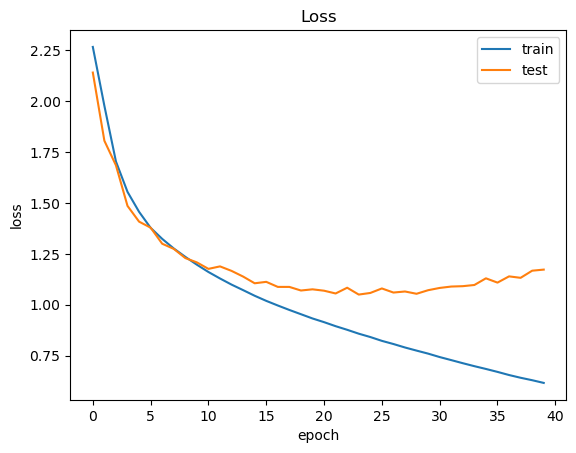

[39/40]		 LR: Train acc: 78.3	 Train loss: 0.616	 Test acc: 63.6	 Test loss: 1.17
Stop train


In [17]:
print("Start train")
log = {"epoch": [], "train_acc": [], "train_loss": [], "test_acc": [], "test_loss": []}

for epoch in range(config["total_epochs"]):
    train_acc, train_loss = train_loop(train_dataloader, model, criterion, optimizer)
    test_acc, test_loss = test_loop(test_dataloader, model, criterion)

    if epoch % config["save_epoch"] == 0:
        state = {
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "loss": test_loss,
            "acc": test_acc,
            "optimizer": optimizer.state_dict(),
            "criterion": criterion.state_dict(),
        }
        save_checkpoint(config["save_path"], state, epoch, '')
            

    log["epoch"].append(epoch)
    log["train_loss"].append(train_loss)
    log["test_loss"].append(test_loss)

    clear_output(wait=True)

    plt.plot(log["epoch"], log["train_loss"], label="train")
    plt.plot(log["epoch"], log["test_loss"], label="test")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss")
    plt.show()

    line = "[{}/{}]\t\t LR: Train acc: {:.3}\t Train loss: {:.3}\t Test acc: {:.3}\t Test loss: {:.3}".format(
        epoch,
        config["total_epochs"],
        train_acc,
        train_loss,
        test_acc,
        test_loss
    )
    
    print(line)

print("Stop train")
    
    

## Ручная проверка модели

In [27]:
saved_weights = torch.load("./weights/checkpoint-000020.pth.tar", weights_only=True)
model.load_state_dict(saved_weights["state_dict"])
model.eval()

NeuralNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

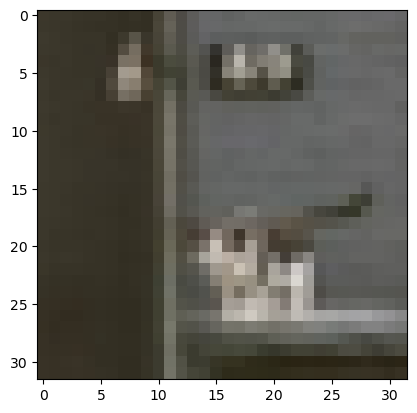

Predicted label: cat	 True label: cat


In [42]:
sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
img, label = test_dataset[sample_idx]
img = img.unsqueeze(0)
img = img / 2 + 0.5 # unnormalize
plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()
print(f"Predicted label: {label_map[model(img.to(device)).argmax(1).sum().item()]}\t True label: {label_map[label]}")